In [ ]:
from google.colab import drive
drive.mount ('/content/drive')
%cd '/content/drive/My Drive/COVID-19_Radiography_Dataset'

Mounted at /content/drive
/content/drive/My Drive/COVID-19_Radiography_Dataset


In [1]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow. keras. applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow. keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow. keras.utils import to_categorical

In [ ]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224]

# training config:
epochs = 20
batch_size = 32

#define paths
covid_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID'
noncovid_path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path +'/*')
noncovid_files = glob(noncovid_path +'/*')

In [ ]:
# Visualize file variable contents
print ("First 5 Covid Files: ", covid_files [0:5])
print ("Total Count: ", len (covid_files) )
print ("First 5 NonCovid Files: ", noncovid_files [0:5])
print ("Total Count: ", len (noncovid_files) )

First 5 Covid Files:  ['/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1069.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1070.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1049.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1026.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/COVID/COVID-1041.png']
Total Count:  172
First 5 NonCovid Files:  ['/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10121.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10116.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/Normal/Normal-10104.png', '/content/drive/MyDrive/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/No

In [ ]:
covid_labels = []
noncovid_labels = []

covid_images = []
noncovid_images = []

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])  # read file
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # arrange format as per keras
    image = cv2.resize(image, (224, 224))  # resize as per model
    covid_images.append(image)  # append image
    covid_labels.append('COVID')  # append class label

for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    noncovid_images.append(image)
    noncovid_labels.append('Normal')  # append class label


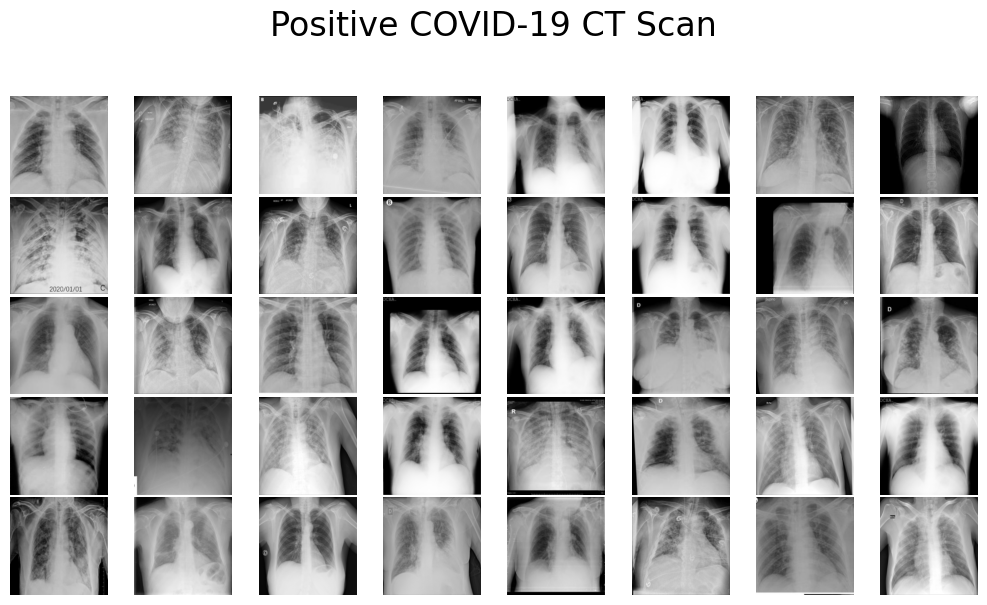

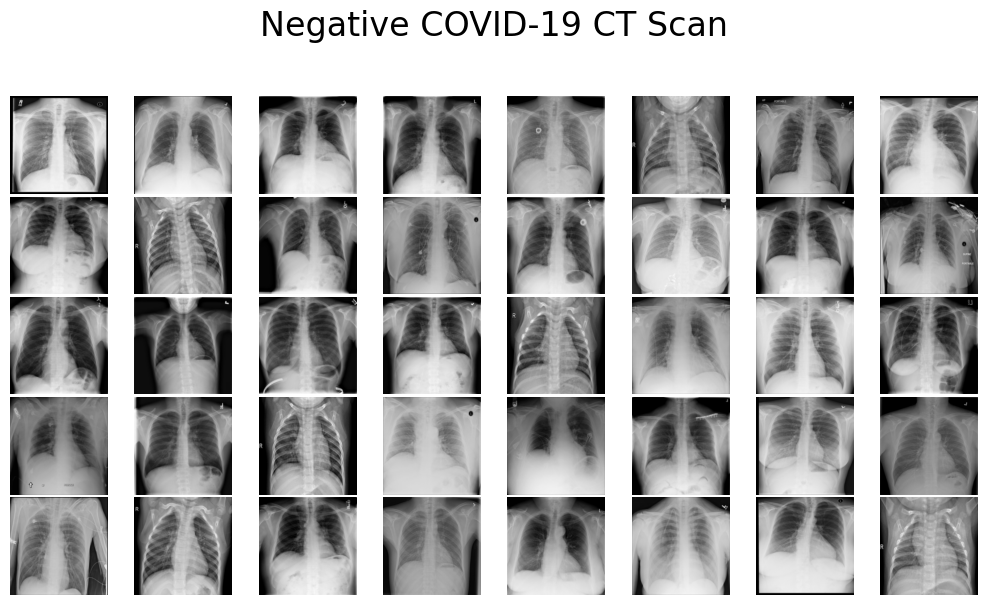

In [ ]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()

plot_images(covid_images, 'Positive COVID-19 CT Scan')
plot_images(noncovid_images, 'Negative COVID-19 CT Scan')


In [ ]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images)/255
noncovid_images = np.array(noncovid_images)/255

In [ ]:
# Split into training and testing sets for both types of images
covid_x_train, covid_x_test, covid_y_train, covid_y_test =train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test =train_test_split(noncovid_images, noncovid_labels, test_size=0.2)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)


In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
plot_images(noncovid_x_train, 'y_train')
plot_images(noncovid_x_test, 'y_test')

In [ ]:
vggModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

outputs = vggModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(1, activation="sigmoid")(outputs)  # Change units to 1 for binary classification

model = Model(inputs=vggModel.input, outputs=outputs)

for layer in vggModel.layers:
    layer.trainable = False

model.compile(
    loss='binary_crossentropy',  # Change loss to 'binary_crossentropy' for binary classification
    optimizer='adam',
    metrics=['accuracy']
)


In [ ]:
train_aug = ImageDataGenerator (
rotation_range=20,
width_shift_range=0.2,
height_shift_range=0.2,
horizontal_flip=True

)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Assuming you have defined train_aug using ImageDataGenerator for data augmentation

history = model.fit(
    train_aug.flow(X_train, y_train, batch_size=batch_size),
    validation_data=train_aug.flow(X_test, y_test),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=epochs
)

# Save Model and Weights
model.save('vgg_ct.h5')
model.save_weights('vgg_weights_ct.hdf5')

# Load saved model
loaded_model = load_model('vgg_ct.h5')


Epoch 1/20
8/8 [==============================] - 8s 621ms/step - loss: 0.8699 - accuracy: 0.5000 - val_loss: 0.8029 - val_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 5s 672ms/step - loss: 0.8159 - accuracy: 0.5000 - val_loss: 0.7101 - val_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 4s 483ms/step - loss: 0.7595 - accuracy: 0.5000 - val_loss: 0.7147 - val_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 4s 476ms/step - loss: 0.7344 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 6s 766ms/step - loss: 0.7272 - accuracy: 0.5000 - val_loss: 0.7036 - val_accuracy: 0.5000
Epoch 6/20
8/8 [==============================] - 4s 492ms/step - loss: 0.7307 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 7/20
8/8 [==============================] - 4s 477ms/step - loss: 0.7255 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.5000
Epoch 8/20
8/8 [====

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 0s 158ms/step


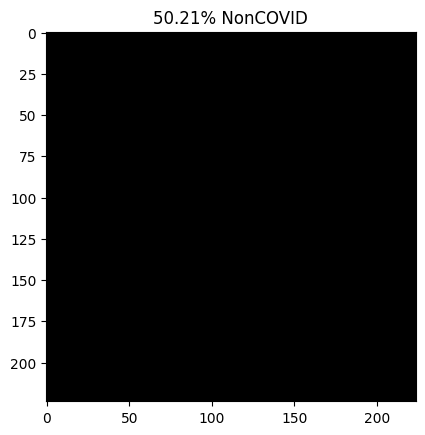

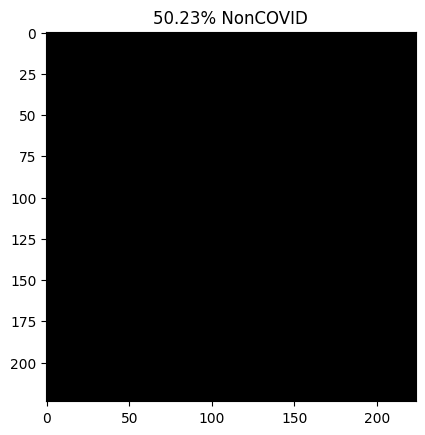

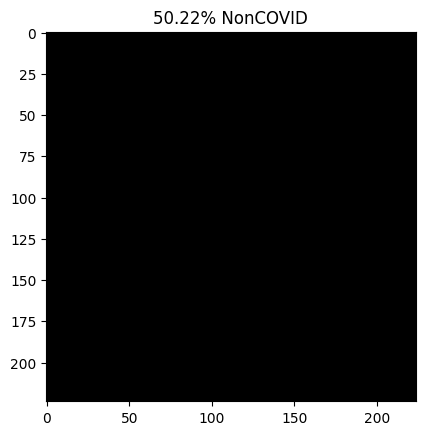

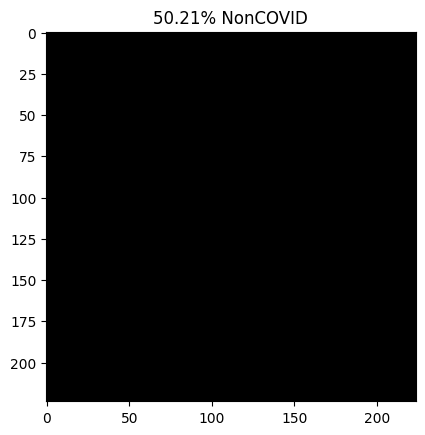

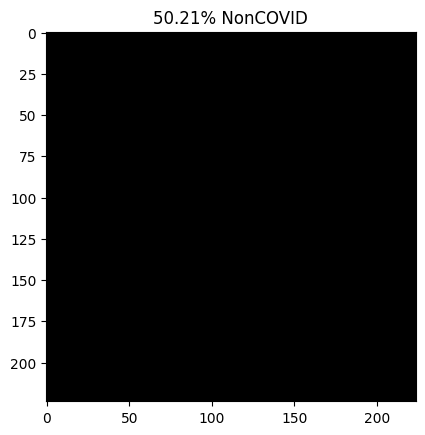

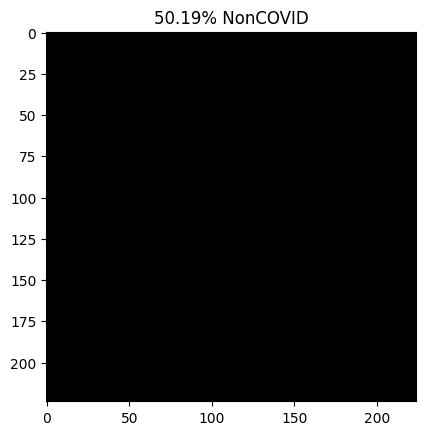

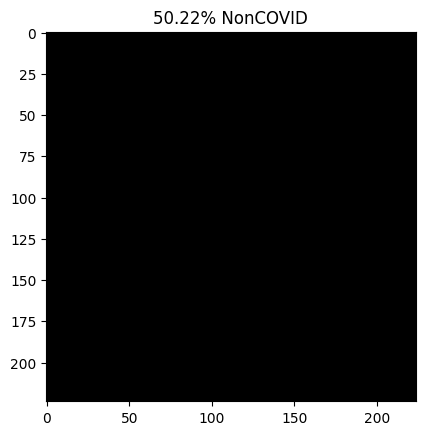

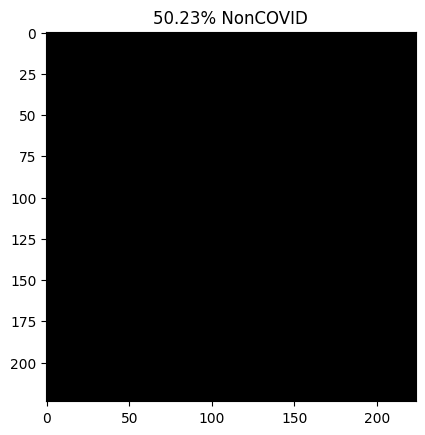

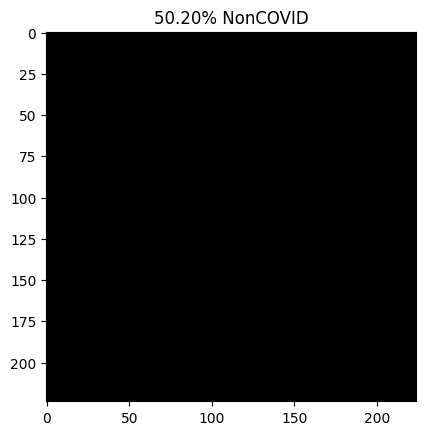

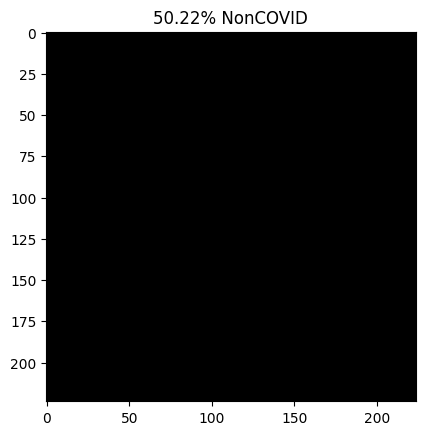

In [ ]:
y_pred = model.predict(X_test, batch_size=batch_size)
prediction = y_pred[0:10]

for index, probability in enumerate(prediction):
    if probability[0] > 0.5:
        plt.title('%.2f' % (probability[0] * 100) + '% COVID')
    else:
        plt.title('%.2f' % ((1 - probability[0]) * 100) + '% NonCOVID')

    plt.imshow(X_test[index])
    plt.show()

# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

In [ ]:
def plot_confusion_matrix (normalize):
  classes = ['COVID', 'NonCOVID']
  tick_marks = [0.5, 1.5]
cn = confusion_matrix(y_test_bin, y_pred_bin, normalize=normalize)
sns.heatmap (cn, cmap='Reds', annot=True)
plt.xticks (tick_marks, classes)
plt.yticks (tick_marks, classes)
plt.title ('Confusion Matrix')
plt.ylabel ('True label')
plt.xlabel ('Predicted label')
plt. show ()


In [ ]:
print ('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

In [ ]:
from sklearn.metrics import classification_report
print (classification_report (y_test_bin, y_pred_bin) )

In [ ]:
plt.plot (history.history['accuracy'])
plt.plot (history.history ['val_accuracy'])

plt.title ('Model Accuracy')
plt.ylabel ('Accuracy')
plt.xlabel ('Epoch')

plt.legend (['Training', 'Testing'])
plt.savefig ('vgg_ct_accuracy.png')
plt. show ()